# Lectura de la Información
En este notebook nos enfocaremos en extraer la data de los archivos comprimidos y unificar las fuentes de datos. Muchas de los métodos/funciones utilizadas, serán cargadas de un archivo utils.py previamente generado para evitar sobrecarga de código en este notebook. Adicionalmente, se proponen nuevas variables a partir del uso de procesos de agrupación por cliente y/o información externa de acceso público.

### Cargar librerías necesarias

In [1]:
from utils import *
import shutil
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Listar archivos comprimidos y extraer archivos

In [2]:
files=[i for i in os.listdir("../data")] ## ../ hace referencia a un nivel atrás al actual, en donde se encuentran los archivos .zip
#_=[shutil.unpack_archive(f'../{i}', f'../data/') for i in files if i.endswith(".zip")]

In [3]:
##extraer paths de cada archivo csv
filepaths=get_csv_filepaths([i.replace(".zip","") if i.endswith(".zip") else i for i in files])

In [15]:
##De acuerdo con validación de negocio, los archivos de siniestros son acumulativos, por tanto solo se debe utilizar el archivo de fin de año

import re


def get_12month_files(file_name:str):
    matches=re.findall("(\d{4}12\/siniestros)",file_name)
    if len(matches)==0:
        return None
    else:
        return file_name

filepaths=[j for j in [get_12month_files(i) if "siniestros" in i else i for i in filepaths] if j is not None]
filepaths=[i for i in filepaths if "old" not in i.lower()]

### Para leer las fuentes de datos se definirán grupos de archivos denotados por la variable filegroups

In [16]:
##NOTA: NO EJECUTAR SI PREVIAMENTE SE HAN GENERADO LOS ARCHIVOS .pickle por filegroup
filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']     
data={}
for filegp in filegroups:
    data[filegp]=read_by_filegroup(filegp,filepaths,save_output=True)

In [6]:
##leer archivos pickle (Checkpoint), ejecutar solo si se ejecutó la celda anterior en algún momento

filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']
data={}
for filegp in filegroups:
    data[filegp]=pd.read_pickle(f"{filegp}.pickle",compression="gzip")
    print(filegp,data[filegp].shape)

personajuridica (359467, 67)
personanatural (4679514, 69)
produccion (3789891, 63)
recaudo (6240094, 33)
siniestro (781983, 34)


### Lectura información tipo de Polizas

In [7]:
FILENAME_RAMOS="../Códigos Ramos-Productos.xlsx"
FILENAME_POLIZAS="../CODIGOS PRODUCTOS SISE.xls"
tipo_ramo,tipo_poliza,tipo_prod=pd.read_excel(FILENAME_RAMOS,sheet_name="tramo",dtype={'cod_ramo': int},skiprows=2),\
                        pd.read_excel(FILENAME_RAMOS,sheet_name="tsubramo",dtype={'cod_ramo': int,'cod_subramo':int},skiprows=2),\
                      pd.read_excel(FILENAME_POLIZAS,sheet_name="productos 3g",dtype={'ramo': int, 'codigo': str})
tipo_ramo.head()

,cod_ramo,txt_desc_redu,txt_desc
0,1,MANEJO,MANEJO
1,2,CUMPLIMIENTO,CUMPLIMIENTO
2,3,INCENDIO,INCENDIO
3,4,SUSTRACCION,SUSTRACCION
4,5,TRANSPORTES,TRANSPORTES


## Esquema de generación de la variable objetivo: churn

- Se deben explorar los campos que permiten unir las diversas fuentes de información, para ello deberá explorarse el código de asegurado o el número de la póliza
- Por definición de negocio, sólo serán tenidos en cuenta productos del segmento Personas:
    - Autos - cod_ramo: 7
    - Responsabilidad Civil- cod_ramo: 13 y Producto 4,6 y 7
    - PreviHogar (producto) - cod_ramo : 89
- Debido a que solo se tiene un año de historia, debemos tomar un periodo base y observar 12 meses después el comportamiento de los asegurados, para encontrar si renovaron o no (churn) su poliza. A través de este análisis generaremos la variable objetivo. Esto puede observarse en el siguiente gráfico. 

![img](images/caso_uso.jpg)


- Sólo serán tenidas en cuenta las pólizas de 12 meses de duración




In [8]:
date_cols=[i for i in data['produccion'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_prod=data['produccion'].drop_duplicates().copy()

In [26]:
##detectar columnas tipo fecha y convertirlas a tipo datetime

date_cols=[i for i in data['produccion'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_prod=data['produccion'].drop_duplicates().copy()
data_prod=data_prod.query("RamoComercial__c in (7,89) or (RamoComercial__c==13 and Producto__c in (4,6,7))")

def col_to_dateutc(column,trim=False):
    if trim:
        return pd.to_datetime(column,errors="coerce").dt.strftime('%m-%Y')
    else:
        return pd.to_datetime(column,errors="coerce")

for col in date_cols:
    data_prod.loc[:,col]=col_to_dateutc(data_prod[col])
    data_prod.loc[:,col+"trim"]=col_to_dateutc(data_prod[col],trim=True)


print("Total filas antes de remover duplicados: ",data['produccion'].shape[0])
print("Total filas después de remover duplicados y filtrar ramos: ",data_prod.shape[0])

Total filas antes de remover duplicados:  3789891
Total filas después de remover duplicados y filtrar ramos:  546876


In [27]:
##obtener descripción tipo de ramo y de subramo de producto
data_prod=data_prod.merge(tipo_ramo[['cod_ramo','txt_desc']].rename(columns={'txt_desc':'tipo_ramo_name'}),how="inner",left_on=['RamoComercial__c'],right_on=['cod_ramo']).drop(columns="cod_ramo")
print(data_prod.shape)

(546876, 69)


### Aspecto Clave

Debido a algunas diferencias de nombres en los archivos de códigos de nombres de producto (ramo y subramo), se asume la siguiente equivalencia para la unión de los datos:

- RamoComercial__c equivale a cod_ramo
- Codigo__c equivale a cod_subramo

In [28]:
##Añadir descripción tipo producto por subramo
       
data_prod.loc[:,'Producto__c']=data_prod.Producto__c.apply(lambda d: try_convert(str(d))).astype(int) ## se debe realizar un paso previo ya que el Producto__c está con valores decimales

In [29]:
data_prod=data_prod.merge(tipo_poliza.rename(columns={'txt_desc':'tipo_prod_desc'}),how="left",left_on=['RamoComercial__c','Producto__c'],right_on=['cod_ramo','cod_subramo'])
data_prod.shape

(546876, 72)

In [30]:
## existen columnas que pueden diferir en valor pero cuyo contenido puede ser unificado al usar procesos de limpieza, (ej. 4.0 vs 4, " DAÑOS" vs "DAÑOS")
## Por tanto se procede a limpiar estas columnas

data_prod.loc[:,'ClaseVehiculo__c']=data_prod.ClaseVehiculo__c.apply(lambda d: try_convert(d))
data_prod.loc[:,'TipoVehiculo__c']=data_prod.TipoVehiculo__c.apply(lambda d: try_convert(d))
data_prod.loc[:,'tipo_ramo_name']=data_prod.tipo_ramo_name.apply(lambda d: str(d).strip().lower())
data_prod.loc[:,'tipo_prod_desc']=data_prod.tipo_prod_desc.apply(lambda d: str(d).strip().lower())


### Agrupación de categorías en variables

Se hacen algunas agregaciones dado que en el archivo de subramos no se encontró mayor nivel de detalle para ramos 7 y 89

In [39]:
#data_prod.loc[:,'tipo_ramo_name']=data_prod.tipo_ramo_name.apply(lambda d: "otras" if d=="nan" else d)
UNDEFINED_RAMOS={7:'automoviles',89:'previhogar'}
data_prod['tipo_prod_desc']=data_prod.apply(lambda d: UNDEFINED_RAMOS[d['RamoComercial__c']] if d['RamoComercial__c'] in UNDEFINED_RAMOS.keys() else d['tipo_prod_desc'],axis=1)

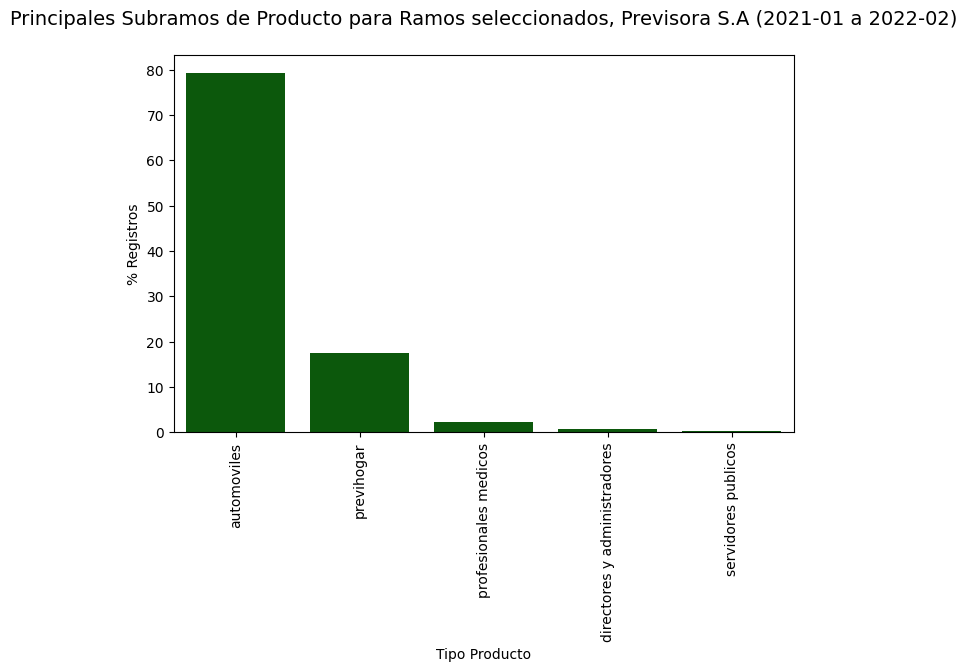

In [42]:
data_tipo_prod=data_prod.tipo_prod_desc.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=100)
sns.barplot(x=data_tipo_prod['index'],y=data_tipo_prod['tipo_prod_desc']*100,data=data_tipo_prod,ax=ax,color="darkgreen");
ax.set_title("Principales Subramos de Producto para Ramos seleccionados, Previsora S.A (2021-01 a 2022-02)\n",size=14)
ax.set_xlabel("Tipo Producto")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

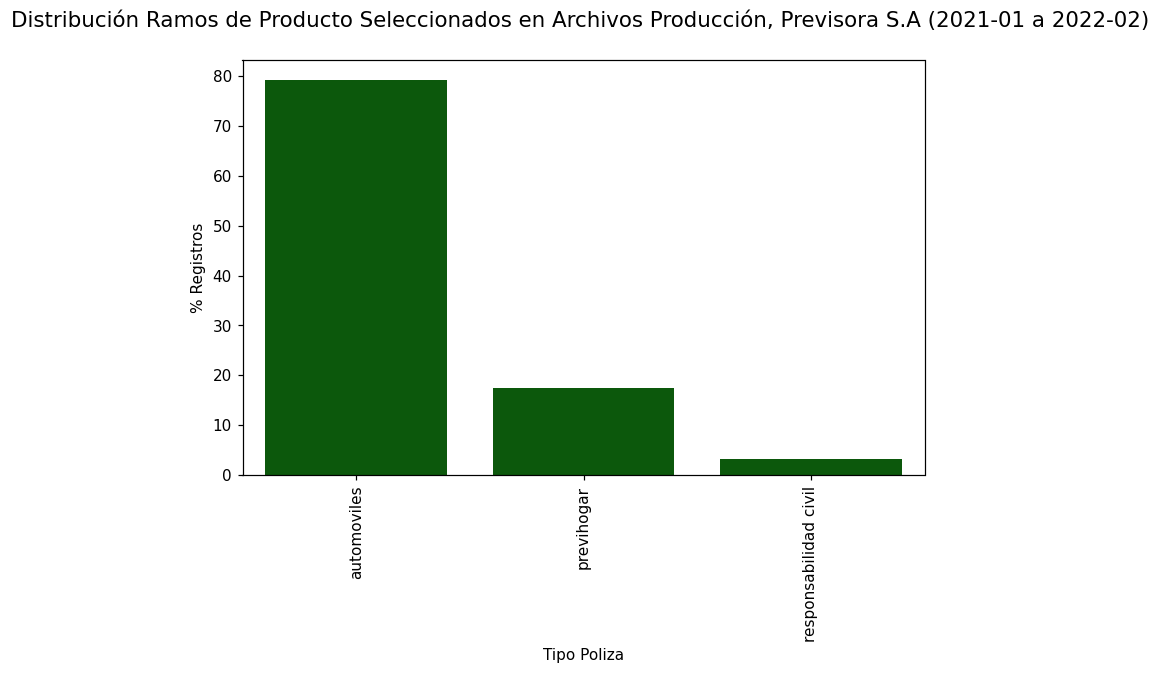

In [43]:
data_tipo_ramo=data_prod.tipo_ramo_name.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=110)
sns.barplot(x=data_tipo_ramo['index'],y=data_tipo_ramo['tipo_ramo_name']*100,data=data_tipo_ramo,ax=ax,color="darkgreen");
ax.set_title("Distribución Ramos de Producto Seleccionados en Archivos Producción, Previsora S.A (2021-01 a 2022-02) \n",size=14)
ax.set_xlabel("Tipo Poliza")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

In [44]:
## eliminar columnas innecesarias generadas en los merge
data_prod.drop(columns=['cod_ramo','cod_subramo'],inplace=True)

In [45]:
#calcular vigencia en días de la poliza, para el MVP asumiremos solo polizas de 365 días.
data_prod.loc[:,'vigencia_dias']=data_prod.apply(lambda d: (d['FechaFinVigencia__c']-d['FechaInicioVigencia__c']).days,axis=1)
data_prod_365=data_prod.query("""vigencia_dias==365""").copy()

### Cálculo de variable objetivo: churn

Para este MVP usaremos las polizas cuya vigencia empieza en enero, febrero o marzo de cada año desde 2018 y observaremos si en el mes de su vencimiento, se observan o no nuevas polizas para el mismo código de asegurado (Asegurado__c) tipo ramo y tipo poliza (RamoTecnico__c,Tipo_poliza_c).

In [54]:
periodos={}
for i in ['01-2018','02-2018','03-2018','01-2019','02-2019','03-2019','01-2020','02-2020','03-2020','01-2021','02-2021']:
    mes,anio=i.split("-")
    periodos[i]=mes+"-"+str(int(anio)+1)

In [57]:
def get_churn_data(init_data,end_data):
        """dada una data de inicio y una final, se calcula cuántos clientes renuevan o no pólizas una vez se vence la actual
           [NOTA] se asume que el churn corresponde a la no renovación en el mes de vencimiento de la póliza actual
        """
        
        churn_data=init_data[['Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','Producto__c','tipo_ramo_name','tipo_prod_desc','ClaseVehiculo__c','MarcaVehiculo__c','MdeloVehiculo__c','TipoVehiculo__c','NumeroPoliza__c','FechaInicioVigencia__ctrim','vigencia_dias','RamoComercial__c','Tipo_poliza_c']].drop_duplicates().\
                merge(end_data[['Asegurado__c','CodigoTipoAsegurado__c','FechaInicioVigencia__ctrim','vigencia_dias','RamoComercial__c','tipo_prod_desc']].drop_duplicates().\
                rename(columns={'vigencia_dias':'end_vig','FechaInicioVigencia__ctrim':'FechaInicio_ctrl'}),how="left",on=['Asegurado__c','CodigoTipoAsegurado__c','RamoComercial__c','tipo_prod_desc'])
        churn_data.loc[:,'churn']=churn_data.end_vig.isnull()
        print("Total Registros: ",churn_data.shape[0])
        return churn_data

results=[]

for ini,end in periodos.items():
    print(f"{ini} - {end}")
    emisiones_inicio,emisiones_end=data_prod_365.query('FechaInicioVigencia__ctrim=="{}"'.format(ini)),data_prod_365.query('FechaInicioVigencia__ctrim=="{}"'.format(end))
    results.append(get_churn_data(emisiones_inicio,emisiones_end))

churn_data=pd.concat(results).drop_duplicates()
print("\n\t\t Total Registros para análisis Churn: ",churn_data.shape[0])


01-2018 - 01-2019
Total Registros:  4827
02-2018 - 02-2019
Total Registros:  6149
03-2018 - 03-2019
Total Registros:  6431
01-2019 - 01-2020
Total Registros:  5553
02-2019 - 02-2020
Total Registros:  5724
03-2019 - 03-2020
Total Registros:  29
01-2020 - 01-2021
Total Registros:  3
02-2020 - 02-2021
Total Registros:  7
03-2020 - 03-2021
Total Registros:  4937
01-2021 - 01-2022
Total Registros:  2182
02-2021 - 02-2022
Total Registros:  4563

		 Total Registros para análisis Churn:  40405


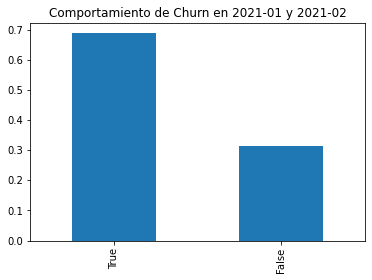

In [58]:
churn_data.churn.value_counts(normalize=True).plot(kind="bar",title="Comportamiento de Churn en 2021-01 y 2021-02");

## Extraer Variables de Dimensiones Adicionales
### Datos de persona natural

In [59]:
#obtener nombre de ciudad usando datos del Dane
ciudades=pd.read_excel("public_data\Codigos Dane municipios.xlsx",header=1,dtype={'CÓDIGO':int})
persona_natural=data['personanatural'].merge(ciudades[['MUNICIPIO','CÓDIGO']].rename(columns={'CÓDIGO':'Ciudad__c','MUNICIPIO':'ciudad_name'}),how="left",on="Ciudad__c").copy()

In [60]:
#seleccionar variables y remover duplicadas
persona_natural=persona_natural[['CodigoAsegurado__c','Activos__c','AnnualRevenue','MontoAnual__c','OtrosIngresos__c','Profesion__pc','EgresosAnuales__c','EstadoCivil__pc','PersonBirthDate','Genero__pc','NumeroIdentificacion__c','ciudad_name']].drop_duplicates()

In [61]:
#calcular edad
from datetime import datetime
persona_natural.loc[:,'PersonBirthDate']=pd.to_datetime(persona_natural.PersonBirthDate,errors="coerce")
persona_natural.loc[:,'edad']=persona_natural.PersonBirthDate.apply(lambda d: (pd.to_datetime(datetime.now())-d).days/365.0 if not pd.isnull(d) else np.nan)

In [62]:
#ciudades con pocos registros se agrupan en una misma categoría
ciudad_name_values=persona_natural.ciudad_name.value_counts(normalize=True).to_dict()
persona_natural.loc[:,'ciudad_name']=persona_natural.ciudad_name.apply(lambda d: "otras" if ((d in ciudad_name_values.keys() and ciudad_name_values[d]<0.01) or pd.isnull(d)) else d)

En el caso de personas naturales, existe información duplicada pero no se tiene una marca de la fecha de actualización de los registros, por tanto, se dejará un único registro por persona basado en la menor cantidad de valores nulos que se tenga. También se renombra la variable `CodigoAsegurado__c` para posteriores transformaciones de unión con otras fuentes de datos. 

In [63]:
persona_natural=persona_natural.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}).drop(columns=['NumeroIdentificacion__c','PersonBirthDate']).drop_duplicates()
persona_natural.loc[:,'n_null']=persona_natural.isnull().sum(axis=1)
persona_natural.sort_values(by=["Asegurado__c","n_null"],ascending=True,inplace=True)
persona_natural=persona_natural[~persona_natural.duplicated(subset="Asegurado__c",keep='first')]
print("Total Registros: ",persona_natural.shape[0])

Total Registros:  1731334


### Datos de Recaudo


In [64]:
# Recaudo data
recaudo=data['recaudo'][['CodigoAsegurado__c','RamoComercial__c','NumeroPoliza__c','Tipo_poliza_c','Producto__c','FechaProduccion__c','CodigoPlanPagos__c','EstadoPagos']].drop_duplicates()
recaudo.loc[:,'Producto__c']=recaudo.Producto__c.apply(lambda d: try_convert(d))
print("Total Registros: ",recaudo.shape[0])

Total Registros:  3395456


### Datos de Siniestro

Para algunos calculos necesitaremos los valores en SMMLV del año de referencia, por tanto obtenemos el histórico de salarios de BANREP


In [65]:
salarios_min=pd.read_excel("public_data\salarios_minimos_brep.xlsx",skiprows=5,skipfooter=12,dtype={'Año (aaaa)':int}).\
    rename(columns={"Salario mínimo mensual (COP)":'sal_mens_min','Año (aaaa)':'anio'})
salarios_min=salarios_min[['anio','sal_mens_min']].set_index('anio').to_dict(orient="index")

In [66]:
##convertir columnas tipo fecha a timestamp

date_cols=[i for i in data['siniestro'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_siniestro=data['siniestro'].drop_duplicates().copy()


for col in date_cols:
    data_siniestro.loc[:,col]=col_to_dateutc(data_siniestro[col])
    data_siniestro.loc[:,col+"trim"]=col_to_dateutc(data_siniestro[col],trim=True)

In [67]:
#calcular valor pagado por siniestro en SMMLV para poder comparar sumarlos o compararlos en el tiempo
data_siniestro_prev=data_siniestro.query("FechaOcurrenciaSiniestro__c<20210131")
data_siniestro_prev.loc[:,'ValorPagadoSiniestros__smmlv']=data_siniestro_prev.apply(lambda d: d['ValorPagadoSiniestros__c']/salarios_min[d['FechaOcurrenciaSiniestro__c'].year]['sal_mens_min'] if d['FechaOcurrenciaSiniestro__c'].year in salarios_min.keys() else salarios_min[2020],axis=1)

In [68]:
#calcular años hasta el el 31 de enero de 2021 (fecha desde que inicia el análisis churn)
data_siniestro_prev.loc[:,'tiempo_stro_hasta012021']=data_siniestro_prev.FechaOcurrenciaSiniestro__c.apply(lambda d: (pd.to_datetime("31-01-2021")-d).days/365)

In [69]:
#generar variables por CodigoAsegurado__c
data_siniestro_prev_agg=data_siniestro_prev.groupby(['CodigoAsegurado__c']).agg({'IdentificacionSiniestro__c':lambda x: x.nunique(),\
                        'ValorPagadoSiniestros__smmlv':np.sum,'tiempo_stro_hasta012021':np.min}).reset_index().\
                        rename(columns={'IdentificacionSiniestro__c':'total_siniestros','ValorPagadoSiniestros__smmlv':'total_pagado_smmlv','tiempo_stro_hasta012021':'anios_ultimo_siniestro'})
data_siniestro_prev_agg.head()

,CodigoAsegurado__c,total_siniestros,total_pagado_smmlv,anios_ultimo_siniestro
0,14,1,0.000000,3.361644
1,18,6,143.300143,0.572603
2,137,11,283.279518,0.657534
3,147,31,98.379429,0.819178
4,151,1,0.000000,1.101370


## Data Producción

En esta información reutilizaremos los pasos generados para obtener la variable objetivo.Sin embargo, gran cantidad de variables requeridas para el posterior análisis descriptivo,ya se encuentran integradas en el objeto `churn_data`.

In [70]:
#obtener generación de polizas previas al primer mes de análisis de churn 
data_prod_prev=data_prod.query("FechaInicioVigencia__c<20201231")

In [71]:
#total de productos previos al mes base de análisis de churn
prod_prev=data_prod_prev.groupby(["Asegurado__c","CodigoTipoAsegurado__c"]).agg({'Producto__c':lambda x: x.nunique()}).reset_index().rename(columns={'Producto__c':'n_prod_prev'})

## Integrar variables

Integración de todas las fuentes de datos procesadas previamente

In [72]:
def integrate_data(data_base: pd.DataFrame):
    """integra data_base con toda la demás información disponible en las dimensiones consideradas"""

    base_data=data_base.copy()
    #produccion
    base_data=base_data.merge(prod_prev,how="left",on=["Asegurado__c","CodigoTipoAsegurado__c"])
    #siniestros
    base_data=base_data.merge(data_siniestro_prev_agg.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}),how="left",on="Asegurado__c")
    #personanatural
    base_data=base_data.merge(persona_natural,how="left",on="Asegurado__c")
    return base_data

In [73]:
churn_data_out=integrate_data(churn_data)

In [202]:
#avoid until validation
#recaudo.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}).sort_values(by=['Asegurado__c','Producto__c','RamoTecnico__c','Tipo_poliza_c','NumeroPoliza__c']).drop_duplicates()
#churn_data.merge(recaudo.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}).drop(columns=['EstadoPagos']).drop_duplicates(),how="left",on=['Asegurado__c','Producto__c','RamoTecnico__c','Tipo_poliza_c','NumeroPoliza__c']).shape

## Exportar churn data

Dado que se hallaron los clientes y su comportamiento en el análisis de churn, exportamos la data para su posterior uso en el análisis exploratorio

In [75]:
churn_data_out.drop(columns=['FechaInicio_ctrl','vigencia_dias','end_vig','n_null','Tipo_poliza_c','RamoComercial__c','Producto__c']).drop_duplicates().to_csv("churn_data.csv",sep=";",index=False)

## Data para validación Posterior

Usaremos un set de datos de pólizas generadas en febrero de 2022 para un uso posterior del caso de negocio



In [76]:
emisiones_final_feb=data_prod_365.query('FechaInicioVigencia__ctrim=="02-2022"')

In [81]:
polizas_feb22=integrate_data(emisiones_final_feb[['Asegurado__c', 'CodigoTipoAsegurado__c', 'PuntoVenta__c',
       'Producto__c', 'tipo_ramo_name', 'tipo_prod_desc', 'ClaseVehiculo__c',
       'MarcaVehiculo__c', 'MdeloVehiculo__c', 'TipoVehiculo__c',
       'NumeroPoliza__c', 'FechaInicioVigencia__ctrim', 'vigencia_dias',
       'RamoComercial__c', 'tipo_prod_desc']])

In [83]:
polizas_feb22.drop(columns=['vigencia_dias','n_null','RamoComercial__c','Producto__c']).drop_duplicates().to_csv("polizas_feb22.csv",sep=";",index=False)